In [40]:
from simulation import minimal_model
from sampling import grid
import matplotlib.pyplot as plt
import numpy as np

In [33]:
eg = grid.EqualGrid()
stack = eg.sample_stack([(0, 100), (0, 100)], 100)
print(stack, len(stack))

[(0.5, 0.5), (0.5, 1.5), (0.5, 2.5), (0.5, 3.5), (0.5, 4.5), (0.5, 5.5), (0.5, 6.5), (0.5, 7.5), (0.5, 8.5), (0.5, 9.5), (0.5, 10.5), (0.5, 11.5), (0.5, 12.5), (0.5, 13.5), (0.5, 14.5), (0.5, 15.5), (0.5, 16.5), (0.5, 17.5), (0.5, 18.5), (0.5, 19.5), (0.5, 20.5), (0.5, 21.5), (0.5, 22.5), (0.5, 23.5), (0.5, 24.5), (0.5, 25.5), (0.5, 26.5), (0.5, 27.5), (0.5, 28.5), (0.5, 29.5), (0.5, 30.5), (0.5, 31.5), (0.5, 32.5), (0.5, 33.5), (0.5, 34.5), (0.5, 35.5), (0.5, 36.5), (0.5, 37.5), (0.5, 38.5), (0.5, 39.5), (0.5, 40.5), (0.5, 41.5), (0.5, 42.5), (0.5, 43.5), (0.5, 44.5), (0.5, 45.5), (0.5, 46.5), (0.5, 47.5), (0.5, 48.5), (0.5, 49.5), (0.5, 50.5), (0.5, 51.5), (0.5, 52.5), (0.5, 53.5), (0.5, 54.5), (0.5, 55.5), (0.5, 56.5), (0.5, 57.5), (0.5, 58.5), (0.5, 59.5), (0.5, 60.5), (0.5, 61.5), (0.5, 62.5), (0.5, 63.5), (0.5, 64.5), (0.5, 65.5), (0.5, 66.5), (0.5, 67.5), (0.5, 68.5), (0.5, 69.5), (0.5, 70.5), (0.5, 71.5), (0.5, 72.5), (0.5, 73.5), (0.5, 74.5), (0.5, 75.5), (0.5, 76.5), (0.5, 77

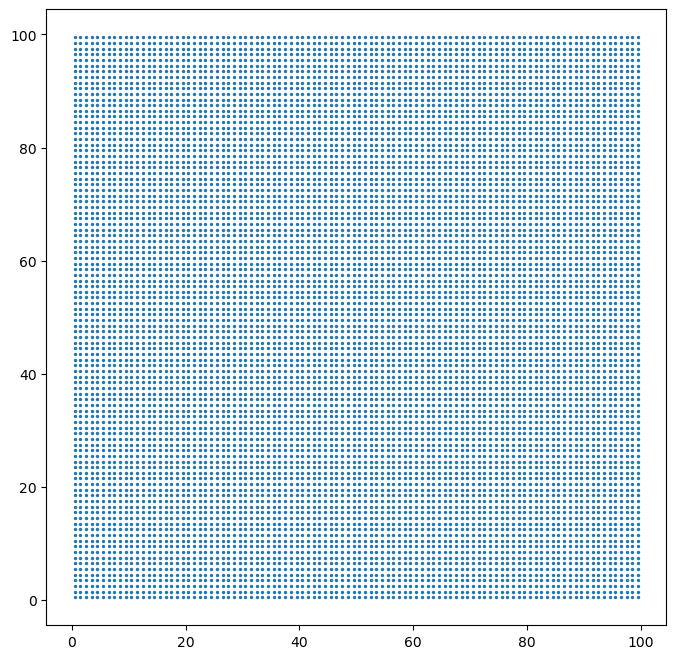

In [39]:
x, y = [x for x, _ in stack], [y for _, y in stack]
fig, ax = plt.subplots(dpi=100, figsize=(8,8))
ax.scatter(x, y, s=2)
plt.show()

In [41]:
dt: float = 0.5     # Time step in years
# Define the physical parameters
r, c, i, d, s = 2.1, 2.9, -0.7, 0.04, 0.4 
Wo, a, Et, Eo, k, b, C = 5e-4, 4.02359478109, 0.021, 0.084, 0.05, 0.28, 1e-4
alpha = np.log(Wo/C)/a

def dX_dt(B,D,g):
    dB_dt_step = (1-(1-i)*np.exp(-1*D/d))*(r*B*(1-B/c))-g*B/(s+B)
    dD_dt_step = Wo*np.exp(-1*a*D)-np.exp(-1*B/b)*(Et+np.exp(-1*D/k)*(Eo-Et))-C
    return dB_dt_step, dD_dt_step

def apply_change(B, delta_B, D, delta_D, clip=True):
    if clip:
        B = np.clip(B + (delta_B * dt), 0.0, c)
        D = np.clip(D + (delta_D * dt), 0.0, alpha)
    else:
        B += (delta_B * dt)
        D += (delta_D * dt)
    return B, D

In [136]:
g = 1.7
B_lim, D_lim = 2.9, 0.4
B_vals = np.linspace(0.01, B_lim, 100)  # Range of B values
D_vals = np.linspace(0.01, D_lim, 100)     # Range of D values

D_grid, B_grid = np.meshgrid(D_vals, B_vals)

# Define the vector field
dB_dt, dD_dt = dX_dt(B_grid, D_grid, g)

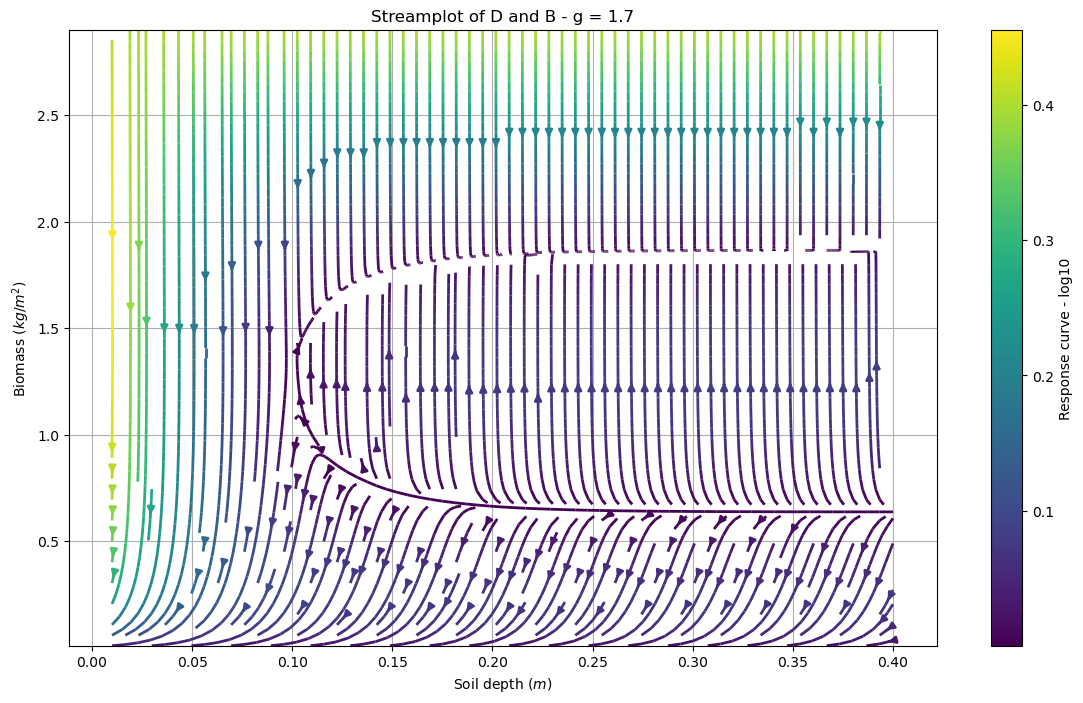

In [286]:
# Calculate magnitude of rate of change
magnitude = np.sqrt(dB_dt**2 + dD_dt**2)

# Apply logarithmic scale to magnitude
magnitude = np.log10(magnitude + 1)  # Adding 1 to avoid log(0)

# Create the streamplot with colormap representing magnitude of rate of change
plt.figure(figsize=(14, 8))
stream = plt.streamplot(D_grid, B_grid, dD_dt, dB_dt, color=magnitude, cmap='viridis', density=2, minlength=0.01, linewidth=2)

# Add colorbar
plt.colorbar(label='Response curve - log10')

# Plot formatting
plt.xlabel('Soil depth ($m$)')
plt.ylabel('Biomass ($kg/m^2$)')
plt.title(f'Streamplot of D and B - g = {g}')
plt.grid(True)
plt.show()

In [214]:
grad_B, _ = np.gradient(dB_dt)
_, grad_D = np.gradient(dD_dt)
grad_D.shape

(100, 100)

In [ ]:
stream.lines.get_segments()

In [252]:
def plot_lines(st_eq, un_eq):
    for unstable in un_eq:
        plt.plot(unstable[:,0], unstable[:,1], linestyle = 'dashed',
                linewidth=2, color = 'black')

    for stable in st_eq:
        plt.plot(stable[:,0], stable[:,1], linestyle = 'solid',
                linewidth=2, color = 'black')

def eq_lines(lines, gradient, B_lim, D_lim):
    grad_stab = gradient < 0
    print(grad_stab.shape)
    dashed_lines = []
    solid_lines = [] 

    for vertices in np.array(lines.get_segments()):  # Wrap LineCollection in a list
        if len(vertices) < 2:
            continue
        indices = (np.array(vertices)//np.array([(B_lim+1E-5)/10, (D_lim+1E-6)/10])).astype(int)
        stability = grad_stab[indices[:,0], indices[:,1]]
        current_line = vertices[0]

        for i in range(len(vertices) - 1):
            if stability[i] != stability[i+1]:
                midpoint = (vertices[i] + vertices[i+1]) / 2
                current_line = np.vstack([current_line, midpoint])
            if stability[i]:
                solid_lines.append(current_line)
            else:
                dashed_lines.append(current_line)
            current_line = vertices[i+1]

        if stability[-1]:
            solid_lines.append(current_line)
        else:
            dashed_lines.append(current_line)

    return np.array(solid_lines), np.array(dashed_lines)

solid_eq_lines, dashed_eq_lines = eq_lines(stream.lines, grad_B, B_lim, D_lim)

plot_lines(solid_eq_lines, dashed_eq_lines)


(100, 100)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [253]:
dashed_eq_lines

array([], dtype=float64)

In [266]:
def plot_lines(st_eq, un_eq):
    for unstable in un_eq:
        plt.plot(unstable[:,0], unstable[:,1], zs=0, zdir='z', linestyle = 'dashed',
                linewidth=2, color = 'black', zorder=10)

    for stable in st_eq:
        plt.plot(stable[:,0], stable[:,1], zs=0, zdir='z', linestyle = 'solid',
                linewidth=2, color = 'black', zorder=11)
        
def eq_lines(contour, gradient, B_lim, D_lim, n_sq):
  # Find for what regions the equilibrium is stable
  grad_stab = gradient < 0

  dashed_lines = []
  solid_lines = [] 
  lines = contour.allsegs[0]
  # print(lines)
  for line in lines:
    print('line')
    if len(line) < 1:
      continue
    indices = (np.array(line)//np.array([(B_lim+1E-5)/n_sq, (D_lim+1E-6)/n_sq])).astype(int)
    stability = grad_stab[indices[:,0], indices[:,1]]
    current_line = line[0]

    for i in range(len(line)-1):
      if (stability[i] != stability[i+1]):
        midpoint = (line[i] + line[i+1])/2
        current_line = np.vstack([current_line, midpoint])
        if stability[i]:
          solid_lines.append(current_line)
        else:
          dashed_lines.append(current_line)
        current_line = midpoint
      current_line = np.vstack([current_line, line[i+1]])

    if stability[-1]:
          solid_lines.append(current_line)
    else:
      dashed_lines.append(current_line)
  return np.array(solid_lines), np.array(dashed_lines)

line
(1, 99, 2)


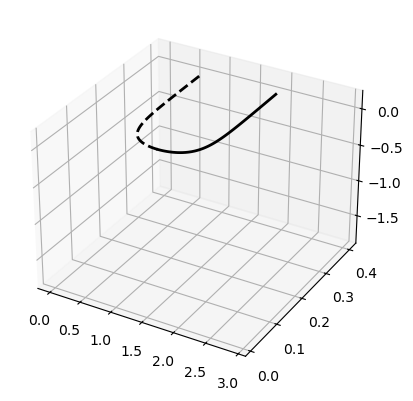

In [280]:
import matplotlib.colors as mc
# Create a desaturated version of the colormap
my_cmap = plt.cm.jet
desaturation = 0.8
jet_colors = my_cmap(np.arange(my_cmap.N))
jet_colors_hsv = mc.rgb_to_hsv(jet_colors[:, :3])
jet_colors_hsv[:, 1] *= desaturation
jet_colors_desaturated = mc.hsv_to_rgb(jet_colors_hsv)
my_cmap_desaturated = mc.ListedColormap(jet_colors_desaturated)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(B_grid, D_grid, dB_dt, cmap=my_cmap_desaturated, linewidth=0.25, edgecolor = 'black',  alpha=1, shade=False)
dB_dt_0 = ax.contour3D(X=B_grid, Y=D_grid, Z=dB_dt, levels = [0.0], linewidths=0)
st_eq_B, un_eq_B = eq_lines(dB_dt_0, grad_B, B_lim, D_lim, 100)
print(st_eq_B.shape)
plot_lines(st_eq_B, un_eq_B)